The Australian DEM is 35GB, and hosted by the DEA [here](https://data.dea.ga.gov.au/?prefix=projects/elevation/ga_srtm_dem1sv1_0/)
AWS bucket name to use to access the data is `dea-public-data`

## Original Data Source

*SRTM-derived 1 Second Digital Elevation Models Version 1.0*

The 1 second Shuttle Radar Topography Mission (SRTM) Digital Elevation
Models Version 1.0 package comprises three surface models: the Digital
Elevation Model (DEM), the Smoothed Digital Elevation Model (DEM-S)
and the Hydrologically Enforced Digital Elevation Model (DEM-H).

### sources and guides
[DEA guide to accessing data from their public S3 bucket using STAC](https://docs.dea.ga.gov.au/guides/setup/gis/stac/)

[Downloading and streaming data using STAC metadata](https://docs.dea.ga.gov.au/notebooks/How_to_guides/Downloading_data_with_STAC/)

In [51]:
import os
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import leafmap.leafmap as leafmap
import pystac_client
import stackstac
import pyproj
from dask.distributed import Client

import tempfile #remove after testing
import matplotlib.pyplot as plt #remove after testing   


1. Set environment variable for AWS and start a Dask client for parallel computation (needed for stackstac)
2. Read the boundary GeoJSON file and extract the bounding box
3. Open the STAC catalogs for DEM and RGB data
4. Define the collections for DEM and RGB data
5. Set the date range for the RGB data
6. Define spatial projection information

In [52]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
client = Client()

geom_gpd = gpd.read_file('data/temp/dissolved-boundaries.geojson')
bbox = list(geom_gpd.total_bounds)
bbox_temp=geom_gpd.total_bounds

catalog_dem = pystac_client.Client.open("https://explorer.sandbox.dea.ga.gov.au/stac/")
catalog_rgb = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

collection_dem = ['ga_srtm_dem1sv1_0']
collection_rgb = ['sentinel-2-l2a']

start_date = "2023-01-01"
end_date = "2023-02-01"

crs_string = "epsg:3857"
epsg = pyproj.CRS.from_string(crs_string).to_epsg()
resolution = 90 #added to resolve error "Failed to auto-guess CRS/resolution."

print(bbox)

[116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107]


Search for DEM data in the STAC catalog. Note that there is no timeframe filtering here because there is only 1, perpetual DEM in this catalog. If you add a timeframe you will get 0 results.
There are 3 assets in this collection: `dem`, `dem_s` and `dem_h`. All three are based on the NASA SRTM elevation data, so just use `dem_h`.
We will also get the url for the `dem_h` COG, so we can display it on a leafmap later on.

In [53]:
ds_dem = catalog_dem.search(bbox=bbox, collections=collection_dem).item_collection()

# Extract the href for the 'dem_h' asset from each item
cog_urls = [item.assets['dem_h'].href for item in ds_dem]
cog_url = cog_urls[0]



Stack the DEM data, specifying the spatial bounds and desired resolution

In [54]:

dem_stack = stackstac.stack(items=ds_dem,
                            epsg=epsg,
                            resolution=resolution,
                            bounds_latlon=bbox,
                            assets=['dem_h']) #Specify the asset key to use from the STAC items
#dem_stack


One thing to watch out for with stackstac.stack is that you will wind up with a distinct time coordinate for each STAC item that you pass in. To achieve the intuitive representation of the data, you need to flatten the DataArray with respect to day.
Note: if you are only reading a single STAC item, stackstac.mosaic will inadvertently reduce your data along the band dimension (which is definitely not what you want!), hence the conditional statement checking for more than one time coordinate value.
[from here](https://hrodmn.dev/posts/stackstac/)

Here we are getting around the problem by using `isel` to select the first time epoch, as there is only one. A different approach will be needed if working with data across timeframes.

In [55]:
dem = dem_stack.sel(band=["dem_h"]).persist()
dem = dem.isel(time=0)

Save the selected DEM data as a GeoTIFF file

In [58]:
output_filename = "data/temp/clipped_raster.tif"
with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=dem.shape[1],
    width=dem.shape[2],
    count=dem.shape[0],
    dtype=dem.dtype,
    crs=dem.crs,
    transform=dem.transform,
) as dst:
    dst.write(dem)
    


EPSG:3857


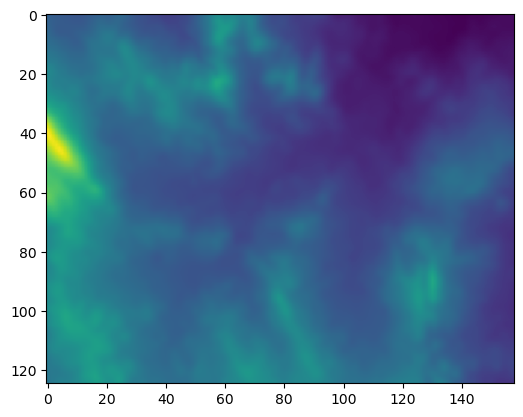

In [62]:
src = rasterio.open(output_filename)
print(src.crs)
plt.imshow(src.read(1))

In [ ]:
# Define the filename for the reprojected raster
reprojected_filename = "data/temp/reprojected_raster.tif"

# Open the original clipped raster
with rasterio.open(output_filename) as src:
    # Define the transform and dimensions for the new raster
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
    
    # Define the metadata for the new raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create and write the reprojected raster
    with rasterio.open(reprojected_filename, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest)

In [63]:

# Initialize a leafmap map
m = leafmap.Map(height="600px", width="900px", draw_control=False, measure_control=False, fullscreen_control=False, attribution_control=False)

m.add_gdf(geom_gpd,  layer_name="boundary", info_mode=None, show=True, style={
    "stroke": True,
    "color": "black",
    "weight": 3,
    "opacity": 1,
    "fill": False})

# Specify the subset of pixels to display using the bounds parameter
m.add_raster('data/temp/clipped_raster.tif', layer_name="Subset Raster", cmap="viridis")

m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## part 2: getting RGB data over the same area as a sanity check

In [ ]:
ds_rgb = catalog_rgb.search(bbox=bbox,
                             datetime=f"{start_date}/{end_date}",
                             collections=collection_rgb).item_collection()


#len(ds_rgb)

rgb_stack = stackstac.stack(items=ds_rgb,
                            epsg=epsg,
                            bounds_latlon=bbox,
                            assets=["blue", "green", "red"]) #bounds_latlong clips the data within the given area
#rgb_stack

In [ ]:
# data = rgb_stack.resample(time="MS").median("time", keep_attrs=True)
# #data

In [ ]:
# def flatten(x, dim="time"):
#     assert isinstance(x, xr.DataArray)
#     if len(x[dim].values) > len(set(x[dim].values)):
#         x = x.groupby(dim).map(stackstac.mosaic)

#     return x


# # round time coordinates so all observations from the same day so they have
# # equivalent timestamps
# data = data.assign_coords(
#     time=data.time.astype("datetime64[D]")
# )

# # mosaic along time dimension
# flat_stack = flatten(data, dim="time")
# flat_stack

In [ ]:
# flat_stack = flat_stack.compute()

# flat_stack.sel(band=["red", "green", "blue"]).plot.imshow(
#     col="time",
#     col_wrap=4,
#     rgb="band",
#     robust=True,
#     size=6,
#     vmin=0,
#     vmax=3000,
#     add_labels=False,
# )